# Steps Toward Exploring Newspaper Data from Lynching Towns

In [4]:
import pandas as pd
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from gensim import corpora, models
import pyLDAvis.gensim
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

## Harry Gates Case in Lexington, MO

I'm starting with just the Harry Gates case and the Lexington Intelligencer.

Newspaper: Lexington Intelligencer, Lexington, MO

Chron Am Page: https://chroniclingamerica.loc.gov/lccn/sn86063623/

Details from the Seguin & Rigby Data:

Date of Lynching: 8/12/1902

Location: Lexington, MO - Lafayette County

Alleged Offense: Murder

Lynching Method: Unknown

Original Source: Chicago Daily Tribune

First Reporting Identified: the St. Louis Republic, August 12th, 1902

### 1) Quick Checks

In [7]:
df = pd.read_csv('lexington_intelligencer_1899-1903.csv')

Does 'harry gates' appear anywhere in the data?

In [12]:
df['text'] = df['text'].astype(str).str.lower()

for index, row in df.iterrows():
    if 'harry gates' in row['text']:
        print(row)

Unnamed: 0                                                          276
url                   https://chroniclingamerica.loc.gov/lccn/sn8606...
text                  jjll el6utciltclu)vol. xxxii lexington, lafaye...
date                                                         1902-08-16
newspaper                                       Lexington Intelligencer
city                                                          Lexington
state                                                                MO
victim_association                                          harry gates
no_punct_text         jjll el6utciltclu vol  xxxii lexington  lafaye...
nltk_tokens           [jjll, el6utciltclu, vol, xxxii, lexington, la...
Name: 276, dtype: object
Unnamed: 0                                                          277
url                   https://chroniclingamerica.loc.gov/lccn/sn8606...
text                  a tf.xas w0.npe3i'ill's gkeit eiscoveri.of ftu...
date                                   

Looks like the Lexington Intelligencer published a full report of the incident just four days later. Is this report in our harry_gates.csv cluster?

In [9]:
harry_gates_reports = pd.read_csv('/Users/matthewkollmer/PycharmProjects/nlp_research/vrt_work/lynch_clusters_02_refined/harry_gates.csv')
harry_gates_reports

,Link Title,URL,text,clippings,victim,city,state,city_mentioned,signal_word_count,sn_code,coverage,reprint_date,longitude,latitude,newspaper
0,"The Daily soliphone.(Paragould, Ark.), January...",https://chroniclingamerica.loc.gov/lccn/sn8905...,"miners begin cauvani. pa., to force recognitio...","assault.24— abe wlthrop ( white ) , at parle ,...",harry gates,lexington,mo,no,12,/lccn/sn89051437,http://dbpedia.org/resource/Paragould%2C_Arkansas,1902-01-02,-90.503056,36.056944,The Daily soliphone
1,Waterbury Democrat. [volume](Waterbury [Connec...,https://chroniclingamerica.loc.gov/lccn/sn9305...,"vol. xy. no 201waterbury. conn, tuesday, augus...",. at 10 o'clock lastnight before coming into p...,harry gates,lexington,mo,yes,10,/lccn/sn93053725,http://dbpedia.org/resource/Waterbury%2C_Conne...,1902-08-12,-73.036944,41.558333,Waterbury Democrat
2,"The evening times. [volume](Washington, D.C.),...",https://chroniclingamerica.loc.gov/lccn/sn8402...,ir fairt fair tonight igh a and dwed wednesday...,workibest bf t 1 t f1bes best sporting s ting ...,harry gates,lexington,mo,yes,66,/lccn/sn84024441,http://dbpedia.org/resource/Washington%2C_D.C.,1902-08-12,-77.036667,38.895000,The evening times
3,"The Paducah sun. [volume](Paducah, Ky.), Augus...",https://chroniclingamerica.loc.gov/lccn/sn8505...,qq04tbc padiicab daily sunvol ix no 187 paduca...,and themen will soon return to workthe buildin...,harry gates,lexington,mo,yes,4,/lccn/sn85052116,http://dbpedia.org/resource/Paducah%2C_Kentucky,1902-08-12,-88.627500,37.072222,The Paducah sun
4,"Rock Island Argus.(Rock Island, Ill.), August ...",https://chroniclingamerica.loc.gov/lccn/sn9205...,"jaot) arguvol. li. 3sto. 253.rock island, ill....",oil to thefinished product a shade of yellowca...,harry gates,lexington,mo,yes,14,/lccn/sn92053934,http://dbpedia.org/resource/Rock_Island%2C_Ill...,1902-08-12,-90.570000,41.470000,Rock Island Argus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,"The Grenada sentinel. [volume](Grenada, Miss.)...",https://chroniclingamerica.loc.gov/lccn/sn8503...,■imma review of 1902the most important happeni...,", at lansing , tex . ; assault.24— abe withrop...",harry gates,lexington,mo,no,12,/lccn/sn85034375,http://dbpedia.org/resource/Grenada%2C_Mississ...,1903-01-10,-89.808900,33.775000,The Grenada sentinel
97,"The Scranton chronicle.(Scranton, Miss.), Janu...",https://chroniclingamerica.loc.gov/lccn/sn8706...,number 1!».i review of 1902]|important happeni...,for threatening murder.22—dually morgan ( colo...,harry gates,lexington,mo,no,12,/lccn/sn87065600,http://dbpedia.org/resource/Pascagoula%2C_Miss...,1903-01-10,-88.558611,30.364694,The Scranton chronicle
98,"Barbour County index. [volume](Medicine Lodge,...",https://chroniclingamerica.loc.gov/lccn/sn8201...,a review of1902the most important happenings l...,"tex . ; assault.24 abe withrop ( white ) , at ...",harry gates,lexington,mo,yes,29,/lccn/sn82015080,http://dbpedia.org/resource/Medicine_Lodge%2C_...,1903-01-14,-98.581111,37.284444,Barbour County index
99,"Water Valley progress.(Water Valley, Miss.), J...",https://chroniclingamerica.loc.gov/lccn/sn8706...,j_the coal st'rike. \mar.18—hard coal miners b...,", at lansing , tex . ; assault.24— abe withrop...",harry gates,lexington,mo,yes,28,/lccn/sn87065501,http://dbpedia.org/resource/Water_Valley%2C_Mi...,1903-01-24,-89.631100,34.153600,Water Valley progress


Yep: it's in the harry_gates.csv file, row 62.

### 2) Prepare the Data for Analysis

In [6]:
df.head()

,Unnamed: 0,url,text,date,newspaper,city,state,victim_association
0,0,https://chroniclingamerica.loc.gov/lccn/sn8606...,"I,emgton Intelligencer;.. tifrLEXINGTON, LAFAY...",1901-04-13,Lexington Intelligencer,Lexington,MO,harry gates
1,1,https://chroniclingamerica.loc.gov/lccn/sn8606...,"The Intelligencer.I. 0. NEALE,Editor and Propr...",1901-04-13,Lexington Intelligencer,Lexington,MO,harry gates
2,2,https://chroniclingamerica.loc.gov/lccn/sn8606...,Gable OM SUn4 Wnt of th Court Noqm.bs. Granula...,1901-04-13,Lexington Intelligencer,Lexington,MO,harry gates
3,3,https://chroniclingamerica.loc.gov/lccn/sn8606...,"WV i! IThe Intelligencer.I. O. NEALE,Editor aa...",1901-04-13,Lexington Intelligencer,Lexington,MO,harry gates
4,4,https://chroniclingamerica.loc.gov/lccn/sn8606...,"Aillr Ancet.?(LEXINGTON, LAFAYETTE COUNTY, MIS...",1901-04-20,Lexington Intelligencer,Lexington,MO,harry gates


The lines below remove punctuation, turn instances of 'harry gates' into one word/token, and tokenize the data using nltk.

In [11]:
df['no_punct_text'] = df['text'].str.replace(r'[^\w\s]', ' ', regex=True)
df['no_punct_text'] = df['no_punct_text'].str.replace('harry gates', 'harry_gates', case=False, regex=False)
df['nltk_tokens'] = df['no_punct_text'].apply(word_tokenize)

### 3) Embeddings

I create a skip-gram model with word2vec. 

In [21]:
skip_model = Word2Vec(df['nltk_tokens'], vector_size=100, window=5, min_count=1, sg=1)
skip_trained_vectors = skip_model.wv

Here are the top twenty most similar words to 'harry gates':

In [22]:
skip_trained_vectors.most_similar('harry_gates', topn=20)

[('brannan', 0.9816655516624451),
 ('onfriday', 0.9797102808952332),
 ('inj', 0.9795268177986145),
 ('avictory', 0.9795230031013489),
 ('oneday', 0.9779763221740723),
 ('bd', 0.9778397679328918),
 ('confederatehome', 0.9777841567993164),
 ('oftown', 0.9774272441864014),
 ('methodistchurch', 0.9760396480560303),
 ('alternate', 0.9759445786476135),
 ('throughtbe', 0.9755989909172058),
 ('hotly', 0.975332498550415),
 ('sdivision', 0.9752483367919922),
 ('billy', 0.9750881195068359),
 ('thescore', 0.9746974110603333),
 ('patron', 0.9743950366973877),
 ('was1', 0.9743573069572449),
 ('ofjune', 0.9743386507034302),
 ('ahot', 0.9742600917816162),
 ('elk', 0.9742445349693298)]

Lots of OCR errors... I may use FastText to fix them, if we futz with embeddings at any point.

### 4) Word Frequency Analysis

Let's think more generally. Here's a wordcloud of the most common words in the data: 

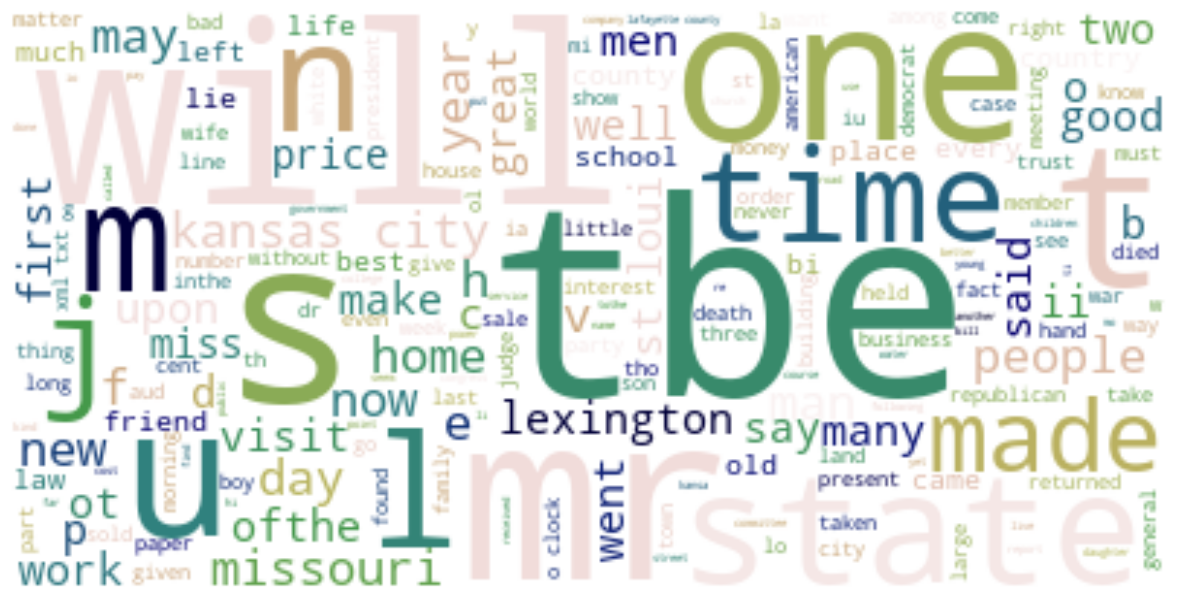

In [28]:
lexington_wordcloud = WordCloud(stopwords=STOPWORDS, colormap='gist_earth', background_color='white').generate(' '.join(df['no_punct_text'].dropna()))

plt.figure(figsize=(15, 10))
plt.imshow(lexington_wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

Lots of OCR errors again... This isn't working too great.

Here's an idea: a wordcloud of the most semantically similar words to 'harry_gates'.



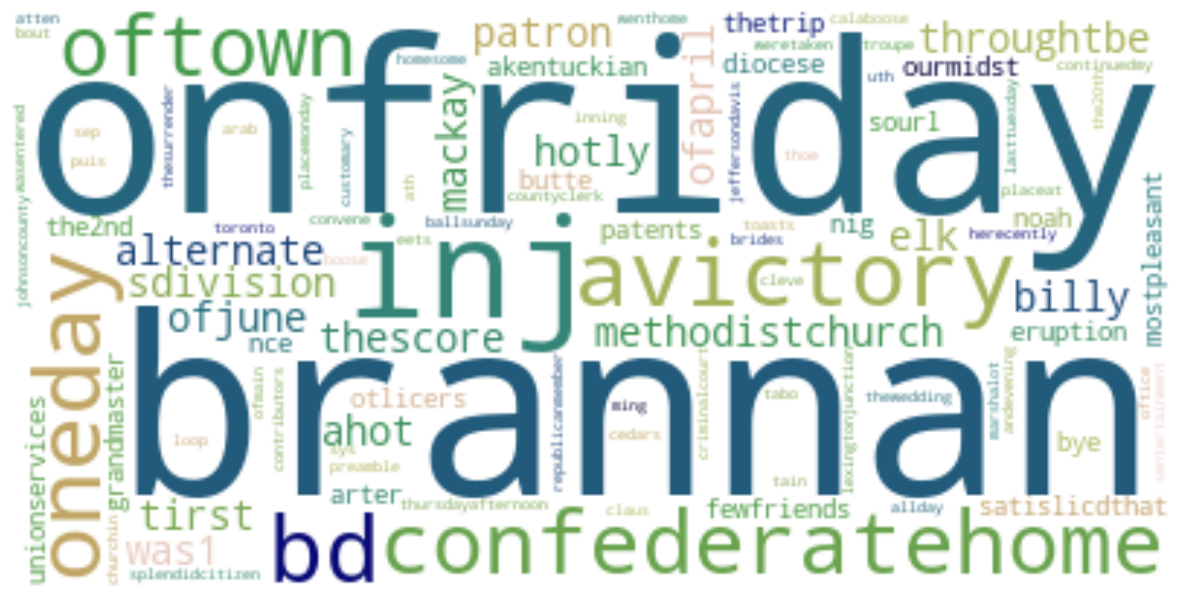

In [31]:
similar_words = [word for word, score in skip_trained_vectors.most_similar('harry_gates', topn=100)]

similar_words = ' '.join(similar_words)

lexington_wordcloud = WordCloud(stopwords=STOPWORDS, colormap='gist_earth', background_color='white').generate(similar_words)

plt.figure(figsize=(15, 10))
plt.imshow(lexington_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

That's a little more interesting. Who is Brannan? After searching the Lexington Intelligencer in the period in question on Chron Am, it's maybe the name of General Brannan, reported on here: https://chroniclingamerica.loc.gov/lccn/sn86063623/1902-04-12/ed-1/seq-1/. Or, it's the name of a Catholic pastor, reported on here: https://chroniclingamerica.loc.gov/lccn/sn86063623/1901-10-19/ed-1/seq-3/. There's also references to the confederates, the town, a Methodist church... Lots of OCR issues. I would need to fix them and then run the word2vec model again and see how that changes things. But who knows how many iterations of OCR corrections it would take?

Let's move on for now. I'll come back to embeddings and word frequency analyses, but I think I need to anchor my explorations in something more than victim names. I need a preliminary lexicon of racially charged/meaningful words, maybe, and then I could do a diachronic analysis. Idk. I'll come back to these things.

Let's try topic modeling, too. What could topic modeling show us about the data?

### 5) Topic Modeling

I start with a function to remove stopwords, and I remove them:

In [32]:
def remove_stopwords(tokens):
    clean_tokens = [word for word in tokens if not word in STOPWORDS]
    return clean_tokens

df['no_stopwords'] = df['nltk_tokens'].apply(remove_stopwords)

Here I'm using Gensim to create an LDA topic model. from the data. I have it set to only words that appear in less than 10% of the pages, only the top 10,000 most frequent words, and only words that appear on at least 2 separate pages. These parameters can (should) be futzed with. Changing them will change the outputs dramatically (i.e., help you find different, potentially relevant topics).

In [40]:
lexington_dictionary = corpora.Dictionary(df['no_stopwords'])
lexington_dictionary.filter_extremes(no_above=0.1, no_below=2, keep_n=10000)
lexington_bags = [lexington_dictionary.doc2bow(doc) for doc in df['nltk_tokens']]

five_lda_topics = models.LdaModel(lexington_bags, num_topics=5, id2word=lexington_dictionary)

In [41]:
lda_display = pyLDAvis.gensim.prepare(five_lda_topics, lexington_bags, lexington_dictionary)
pyLDAvis.display(lda_display)

This was fun! But not sure if it's going to be useful yet. Lots left to explore. But these steps (embeddings, word frequency analysis, topic modeling) could be revisited and applied to different datasets. One thing I think I'll do before coming back to these steps, however, is consider a preliminary lexicon of racially charged/meaningful words. Perhaps once we nail down our model for identifying racially charged or violent text we can use it to build this lexicon? Then I could adapt these steps into a diachronic analysis of the lynching town newspapers (i.e., how can changes in language related to racial violence, mapped over time, appear in embeddings, word frequencies, or topics? And, can those changes tell us something about the racial climate of places before, during, and after a lynching?)

I'll have to think carefully about how to scale these steps, too. Do I look at subsets by region? Or classify newspapers as lynching towns or not (for a comparison)? Do I continue looking at individual lynching town papers and try to tell the story of their racial violence as specific as possible to their respective cases?

Also, maybe this is just an information retrieval exercise. That is, rather than read these papers over the course of years surrounding their racial violence incident, I can assess them as data first and see if anything sticks out as predictive or meaningful.